# Семантическая Сегментация. Часть 3.

## Переключение версии TensorFlow

In [1]:
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [2]:
if 0:
    # !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    # !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    # !cd data && git clone https://github.com/cocodataset/cocoapi
    # !cd data/cocoapi/PythonAPI && make

## Подготовка COCO API

In [3]:
COCO_ROOT = './data/'
# import sys
# sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [8]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.48s)
creating index...
index created!
loading annotations into memory...
Done (t=1.81s)
creating index...
index created!


In [10]:
COCO_dataset_train.img_list = COCO_dataset_train.img_list[:1000]
COCO_dataset_val.img_list = COCO_dataset_val.img_list[:100]

In [12]:
train_ds = COCO_dataset_train.train_dataset(batch_size=8, epochs=1, inp_size=256)
val_ds = COCO_dataset_val.val_dataset(batch_size=16, inp_size=256)

In [10]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [11]:
NUM_EPOCHS = 200
BATCH_SIZE = 16

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss,)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
%%time
hist = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data = val_ds)


Epoch 1/200
125/125 [==============================] - 107s 764ms/step - loss: 0.5826 - val_loss: 0.5697
Epoch 2/200
125/125 [==============================] - 84s 673ms/step - loss: 0.4821 - val_loss: 0.5718
Epoch 3/200
125/125 [==============================] - 84s 674ms/step - loss: 0.4660 - val_loss: 0.7697
Epoch 4/200
125/125 [==============================] - 84s 675ms/step - loss: 0.4627 - val_loss: 0.5206
Epoch 5/200
125/125 [==============================] - 84s 675ms/step - loss: 0.4683 - val_loss: 0.8734
Epoch 6/200
125/125 [==============================] - 84s 674ms/step - loss: 0.4691 - val_loss: 0.5341
Epoch 7/200
125/125 [==============================] - 84s 675ms/step - loss: 0.4462 - val_loss: 0.5776
Epoch 8/200
125/125 [==============================] - 84s 674ms/step - loss: 0.4366 - val_loss: 0.4778
Epoch 9/200
125/125 [==============================] - 84s 674ms/step - loss: 0.4354 - val_loss: 0.5007
Epoch 10/200
125/125 [==============================] - 84s 669

In [ ]:
model.save('saved_model/my_model')

In [15]:
model = tf.keras.models.load_model('saved_model/my_model')

In [16]:
model.evaluate(val_ds)

6/6 [==============================] - 17s 341ms/step - loss: 0.4102


0.4101801812648773

In [99]:
img, mask = next(iter(val_ds.take(1)))

<ipython-input-103-83719de9820e>:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


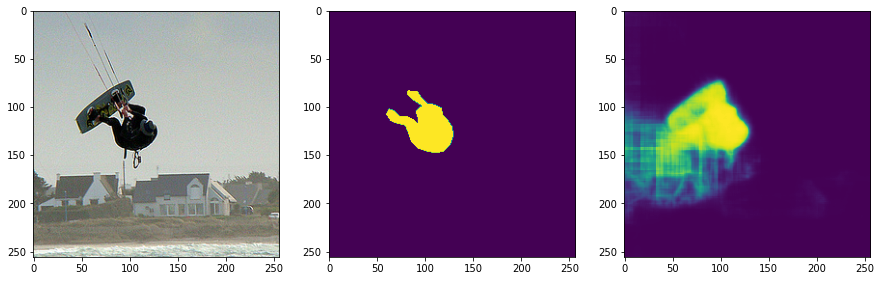

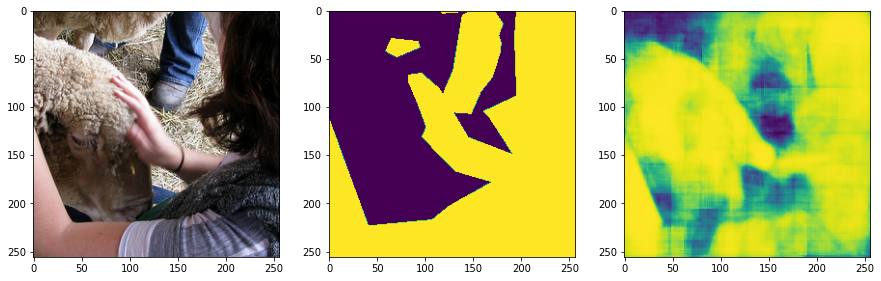

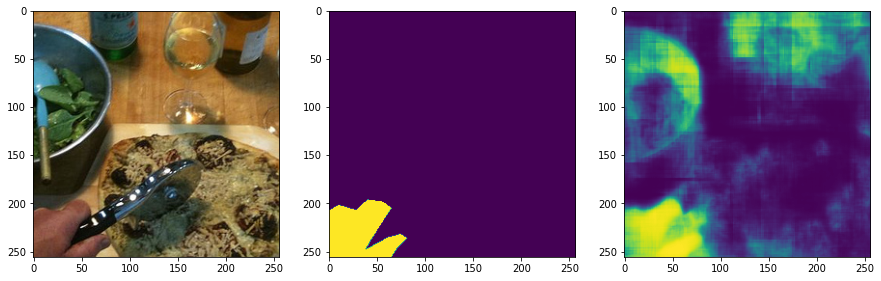

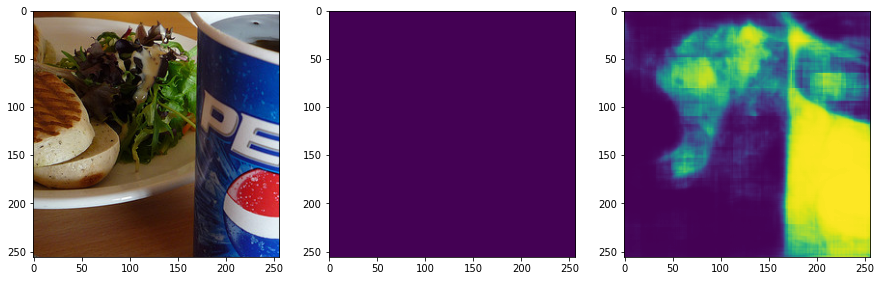

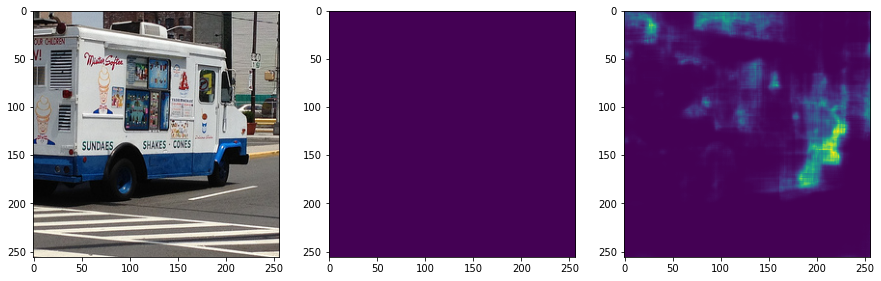

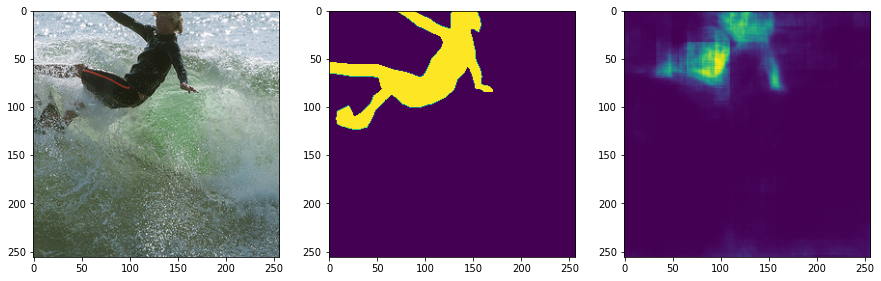

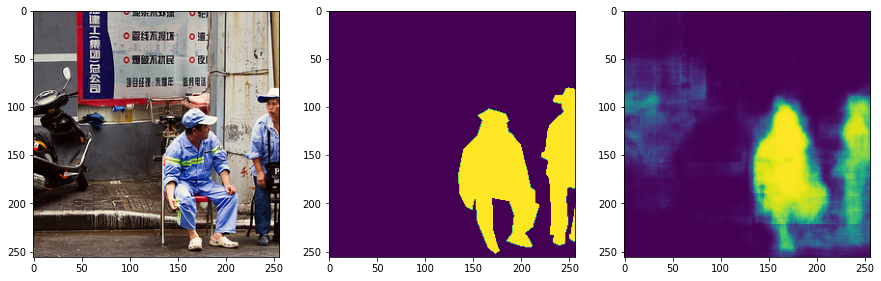

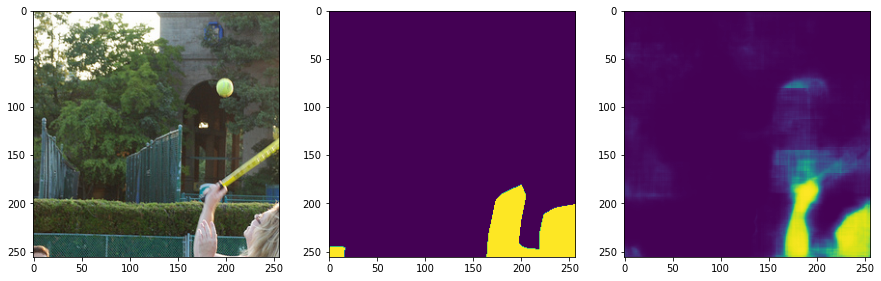

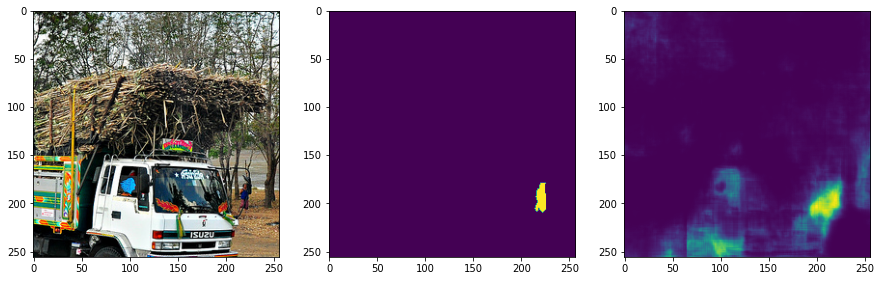

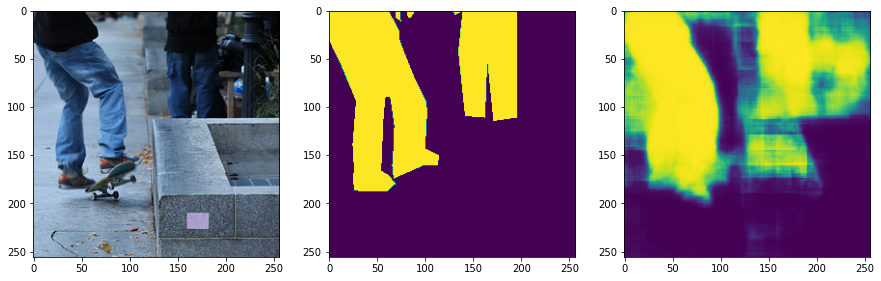

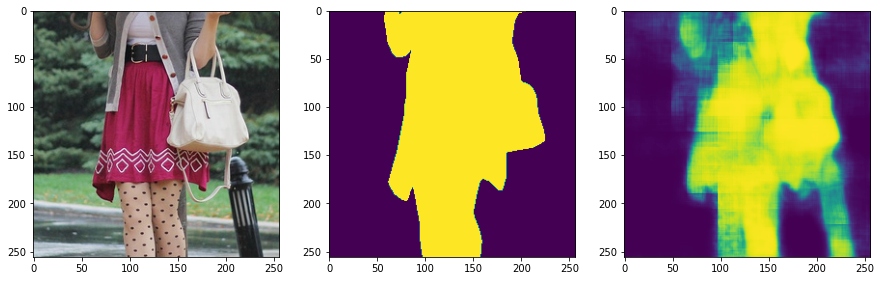

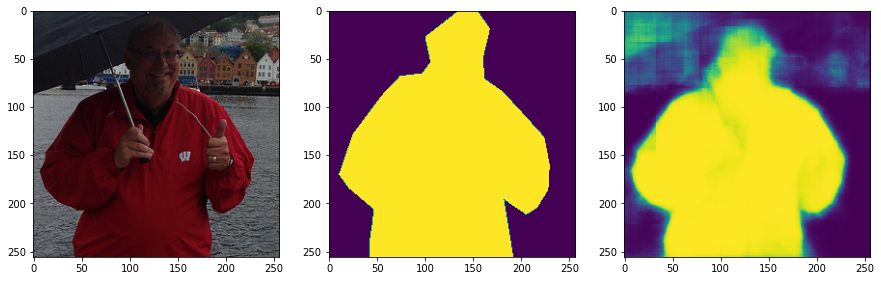

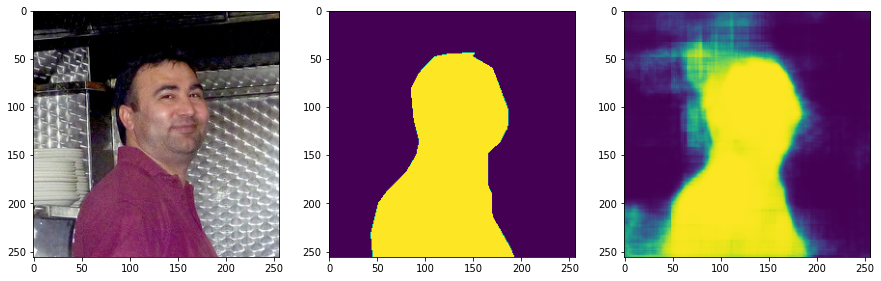

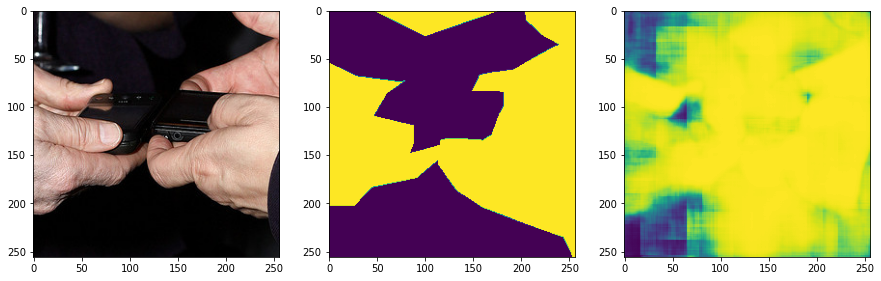

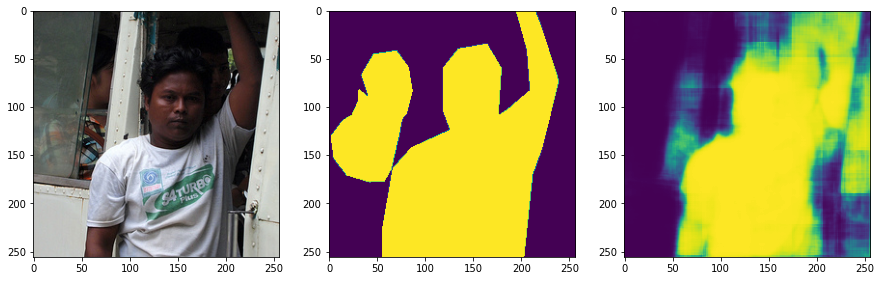

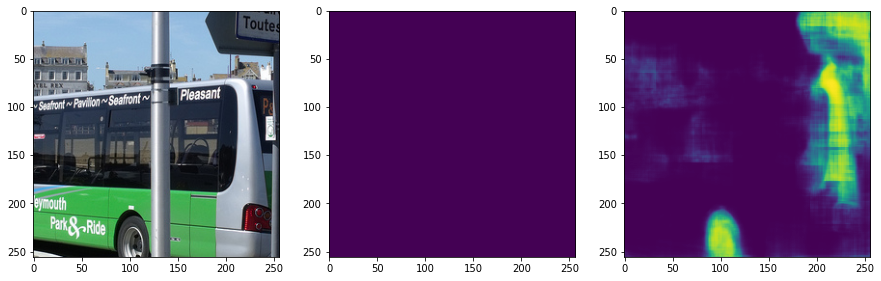

In [103]:

for i in range(16):
    fig, ax  = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(img[i])
    ax[1].imshow(mask[i])
    ax[2].imshow(masks_pred[i])
    plt.show()

Результат неплохой. Добавил в U-net батчнормализацию, чтобы быстрее сходилась. Явно можно добавить еще 200 - 400 эпох, модель покажет себя еще лучше. 